In [0]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
data = sm.datasets.engel.load_pandas().data
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


In [3]:
data.describe()

,income,foodexp
count,235.000000,235.000000
mean,982.473044,624.150111
std,519.230879,276.456997
min,377.058369,242.320202
25%,638.875788,429.688763
50%,883.984917,582.541251
75%,1163.986672,743.881432
max,4957.813024,2032.679190


In [4]:
ols = smf.ols('foodexp ~ income', data).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                foodexp   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1141.
Date:                Mon, 29 Jul 2019   Prob (F-statistic):           9.92e-92
Time:                        16:54:45   Log-Likelihood:                -1445.7
No. Observations:                 235   AIC:                             2895.
Df Residuals:                     233   BIC:                             2902.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    147.4754     15.957      9.242      0.0

In [5]:
mod = smf.quantreg('foodexp ~ income', data)
medianReg = mod.fit(q=.5)
print(medianReg.summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Mon, 29 Jul 2019   No. Observations:                  235
Time:                        16:54:45   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


In [6]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], 
            res.params['income']] + \
            res.conf_int().loc['income'].tolist()
    
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, 
             columns=['q', 'a', 'b', 'lb', 'ub'])

print(models)

      q           a         b        lb        ub
0  0.05  124.880099  0.343361  0.268632  0.418090
1  0.15  111.693660  0.423708  0.382780  0.464636
2  0.25   95.483539  0.474103  0.439900  0.508306
3  0.35  105.841294  0.488901  0.457759  0.520043
4  0.45   81.083647  0.552428  0.525021  0.579835
5  0.55   89.661370  0.565601  0.540955  0.590247
6  0.65   74.033433  0.604576  0.582169  0.626982
7  0.75   62.396584  0.644014  0.622411  0.665617
8  0.85   52.272216  0.677603  0.657383  0.697823
9  0.95   64.103964  0.709069  0.687831  0.730306


In [7]:
ols = smf.ols('foodexp ~ income', data).fit()
ols_ci = ols.conf_int().loc['income'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['income'],
           lb = ols_ci[0],
           ub = ols_ci[1])
print(ols)

{'a': 147.47538852370573, 'b': 0.48517842367692354, 'lb': 0.4568738130184233, 'ub': 0.5134830343354237}


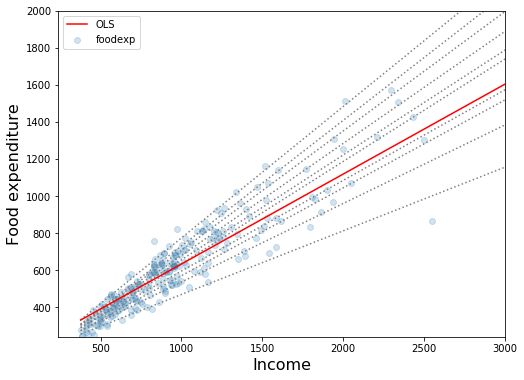

In [8]:
x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.income, data.foodexp, alpha=.2)
ax.set_xlim((240, 3000))
ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('Income', fontsize=16)
ax.set_ylabel('Food expenditure', fontsize=16);

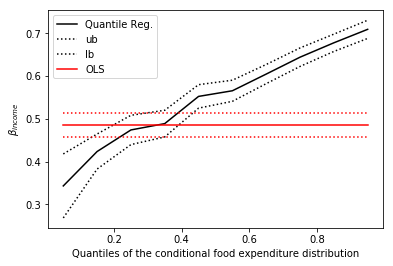

In [9]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend()
plt.show()